# Figure 5

This notebook recreates the figure panels included in Figure 5 of Lee et al. 2021. 



### Description of the Data

The data used in this notebook comes from the experiments described in Lee et al. 2021. Specifically, we have the behavioral and activity of a trained deep RL agent performing a evidence accumulation task from Engelhard et al. 2019. 




## Preparing the Data
### Importing required code packages and modules

In [3]:
ls

Figure 2.ipynb      Figure 4.ipynb      Figure 6.ipynb      Supp Figures.ipynb
Figure 3.ipynb      Figure 5.ipynb      Matlab Scripts/     utils/


In [4]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import sys
from scipy.io import loadmat, savemat
import utils.cnnlstm_analysis_utils as utils
import seaborn as sns
from scipy import stats
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import os

### downloading data

In [6]:
load_prefix = '../../data/logs/VA_maze/'
with open(load_prefix + '5000t_mosttrain_db.p', 'rb') as f:
     [actions_, rewards_, feats_, terms_, vs_, tow_counts_, episode_lengths]  = pickle.load(f)
f.close()
vs = np.hstack(vs_)
terms = np.hstack(terms_)
rewards = np.hstack(rewards_)
ep_rew = np.array([np.sum(r_trial) for r_trial in rewards_])
ep_tow = np.array([np.max(trial, 0) for trial in tow_counts_])
tow_counts = np.vstack(tow_counts_)



weights = utils.get_params_from_zip(load_prefix + 'rl_model_20800000_steps')
# weights.keys()

w_pol = weights['model/pi/w:0']
b_pol = weights['model/pi/b:0']
w_val = np.squeeze(weights['model/vf/w:0'])
b_val = weights['model/vf/b:0']

trial_info = loadmat(load_prefix + 'trialinfo_db.mat')

trial_info = trial_info['trials']
trial_info.dtype.names
choices = utils.extract_field(trial_info, 'choice')
trial_type = utils.extract_field(trial_info, 'trialType')
raw_ypos = utils.extract_field(trial_info, 'position')[:,1]
cueCombos_ = utils.extract_field(trial_info, 'cueCombo')
cuePos_ = utils.extract_field(trial_info, 'cuePos')
cueOnset_ = utils.extract_field(trial_info, 'cueOnset')
raw_ypos_ = [x[:,1] for x in trial_info['position'][0]]
raw_xpos_ = [x[:,0] for x in trial_info['position'][0]]
raw_vpos_ = [x[:,2] for x in trial_info['position'][0]]
ypos_ = [np.hstack([np.array(x[:-1]), x[-2] * np.ones((7,))]) for x in raw_ypos_]
ypos = np.hstack(ypos_)


### Plotting Parameters

In [7]:
# PLOTTING PARAMS
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams.update({'font.family': 'Arial'})

FONT_BG = 25
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # allow text of pdf to be edited in illustrator

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

marker_plots =  {'marker':'.', 'markersize':2, 'markeredgecolor':'k', 'markerfacecolor':'k'}
heatmap_sz = (4, 3.5)
example_sz = (4, 1)


### Organizing Data

Pulling out the specific data that we will use for figure panels

In [8]:
CUEP_LIM = 140
REWP_LEN_S = -16
REWP_LEN_STP = -5
ypos_cuep = np.squeeze(np.dstack([ypos_t[:CUEP_LIM] for ypos_t in ypos_])[:,:,0])
(ep_towdelt_idx, ep_towdiff_idx) = utils.get_ep_tow_idx(ep_tow)


### Calculate Vector RPEs

In [9]:
if os.path.exists(load_prefix + 'pes.p'):
    with open(load_prefix + 'pes.p', 'rb') as f:
         pes  = pickle.load(f)
    f.close()

else: 
    feats = np.vstack(feats_)
    rewards = np.hstack(rewards_)
    terms = np.hstack(terms_)
    start = np.roll(terms,1)
    nsteps = len(terms)
    nfeatures = feats_[0][0].shape[0]
    gamma = 0.99
    # compute per-feature PEs
    pes = np.zeros((nsteps, nfeatures))
    for i in range(0,nsteps-1):
        if (terms[i]): # there is a one-off error-- the SECOND index of the start of the trial accurately measures the start of the trial
            pes[i,:] = rewards[i] / nfeatures -  w_val * feats[i,:]
        else:
            pes[i,:] = rewards[i] / nfeatures +  w_val * (-feats[i,:] + gamma * feats[i+1,:])

    pickle.dump(pes, open(load_prefix + "pes.p", "wb") )

    
# pes split by 5000 trials
pes_ = utils.split_by_ep_len(pes, np.hstack((episode_lengths)))
pes_cuep = np.dstack([pes_i[:CUEP_LIM,:] for pes_i in pes_])
ypos_cuep = np.squeeze(np.dstack([ypos_t[:CUEP_LIM] for ypos_t in ypos_])[:,:,0])


### Find Confirm/Disconfirm Cues

In [13]:
leftCue_ = [trialcue[0][0] -2 for trialcue in cueOnset_]
rightCue_ = [trialcue[1][0] -2 for trialcue in cueOnset_]

diff_ = [np.roll(tow_tr[:,0] - tow_tr[:,1],1) for tow_tr in tow_counts_]
# rolling this by 1 here so that I use 1:n-1 cues to determine confirm/disconfirm! clip makes sure I don't get -1 index
# last tower difference is ALWAYS 0

# positive for Left > Right, 0 for equal, negative for Right > Left at Left Cues
leftCue_confirm = [diff_tr[leftCue_[i]] for (i, diff_tr) in enumerate(diff_)]
rightCue_confirm = [diff_tr[rightCue_[i]] for (i, diff_tr) in enumerate(diff_)]

# get timelocked activity to cues
get_timelocked_cues = lambda pes_, cueLocs: np.dstack([utils.timelock_to_cue(pes_, cueLocs, pes_i) for pes_i in np.arange(64)])


# cues: confirmatory and disconfirmatory
confirmCue_ = [np.sort([*(leftCue_[i])[leftCue_confirm[i] > 0], *(rightCue_[i])[rightCue_confirm[i] < 0]]) for i in np.arange(len(leftCue_))]
dConfirmCue_ = [np.sort([*(leftCue_[i])[leftCue_confirm[i] < 0], *(rightCue_[i])[rightCue_confirm[i] > 0]]) for i in np.arange(len(leftCue_))]


pes_Ccue =  get_timelocked_cues(pes_, confirmCue_)
pes_DCcue = get_timelocked_cues(pes_, dConfirmCue_)

## Figure 5B: Confirm/Disconfirm Model Data

In [14]:
vmin = loadmat(load_prefix + 'sorted_pes_confirmcue.mat')['imedg1']
vmax = loadmat(load_prefix + 'sorted_pes_confirmcue.mat')['imedg2']
norm_pes_Ccue = loadmat(load_prefix + 'sorted_pes_confirmcue.mat')['mrContra']
norm_pes_DCcue = loadmat(load_prefix + 'sorted_pes_confirmcue.mat')['mrIpsi']
sort_order =  np.squeeze(loadmat(load_prefix + 'sorted_pes_confirmcue.mat')['order']) - 1


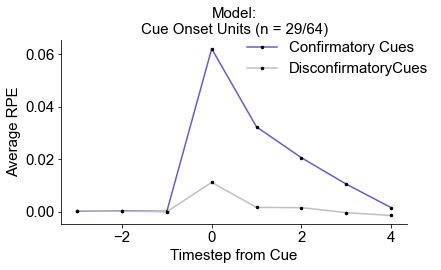

In [15]:
timesteps = np.arange(-3,5)
timesteps_idx = timesteps + 5

units = np.hstack([sort_order[:21], sort_order[40:48]])
marker_plots_big =  {'marker':'.', 'markersize':5, 'markeredgecolor':'k', 'markerfacecolor':'k'}

fig = plt.figure(figsize=(6,4))
scalar_ax = plt.gca()
scalar_ax.plot(timesteps,np.nansum(np.nanmean(pes_Ccue,0)[:,units],-1)[timesteps_idx], 
               **marker_plots_big, label = 'Confirmatory Cues', color = 'slateblue')
scalar_ax.plot(timesteps,np.nansum(np.nanmean(pes_DCcue,0)[:,units],-1)[timesteps_idx], 
               **marker_plots_big, label = 'DisconfirmatoryCues', color = 'silver')

scalar_ax.set_title('Model:\nCue Onset Units (n = ' + str(len(units)) + '/64)', fontsize = 15)
scalar_ax.set_xlabel('Timestep from Cue')
scalar_ax.set_ylabel('Average RPE')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.1, 0.9), frameon= False, loc = 'right')



## Figure 5C: Neural Confirm/Disconfirm Cues

In [18]:
# neural data uses the plot_cdc.m matlab script
neural_plot_data = loadmat('./data/ben_cdc_kernels_contracueunits.mat')
neural_confirm = np.vstack(np.squeeze(neural_plot_data['means_cell'])).T
neural_confirm_sems = np.vstack(np.squeeze(neural_plot_data['sems_cell'])).T
neural_confirm_time = np.squeeze(neural_plot_data['time_vector']).T

Text(13.75, 0.5, 'Kernel amplitude')

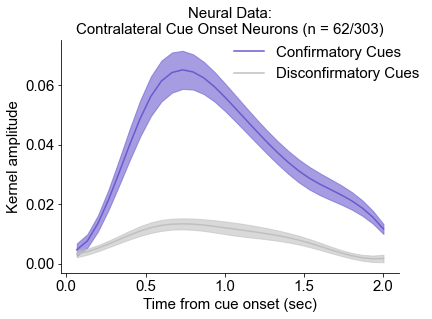

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
for i, [col, label] in enumerate(zip(['slateblue', 'silver'],
                    ['Confirmatory Cues', 'Disconfirmatory Cues'])):
    i = i * 2; # for contracueunits, it's listed as confirm, neutral, disconfirm
    ax.fill_between(neural_confirm_time, neural_confirm[:,i]- neural_confirm_sems[:,i],
                                neural_confirm[:,i] + neural_confirm_sems[:,i],
                                color = col, alpha = 0.6)
    ax.plot(neural_confirm_time,neural_confirm[:,i], color = col, label = label);
ax.legend(bbox_to_anchor=(1.1, 0.9), loc='right', frameon = False)
plt.tight_layout()
ax.set_title('Neural Data:\nContralateral Cue Onset Neurons (n = 62/303)', fontsize = 15)
ax.set_xlabel('Time from cue onset (sec)')
ax.set_ylabel('Kernel amplitude')